# Feature selection
## First experiment: supervised univariate feature selection
1. We define a parameter grid param_grid containing the ranges of hyperparameters we want to search over.
1. We initialize GridSearchCV with our pipeline, parameter grid, cross-validation (cv=5 for 5-fold cross-validation), and scoring metric ('f1' for F1-score).
1. Components of the pipeline:
    1. `StandardScaler`
    1. `SelectKBest` - implements the *supervised univariate feature selection*, considers one at a time the importance of a feature for the classification, using **ANOVA**, the *analysis of variance*, comparing the distribution of the feature values in the partitions generated by the different target values
    1. `SVC` (the experiment could be done with other classifiers)
1. We fit the GridSearchCV object to the training data, which performs hyperparameter tuning and cross-validation to find the best combination of hyperparameters.
1. We extract the best parameters and best F1-score using the best_params_ and best_score_ attributes of the GridSearchCV object.
1. We make predictions on the test data using the best model obtained from GridSearchCV.
1. Finally, we evaluate the accuracy and F1-score of the predictions

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

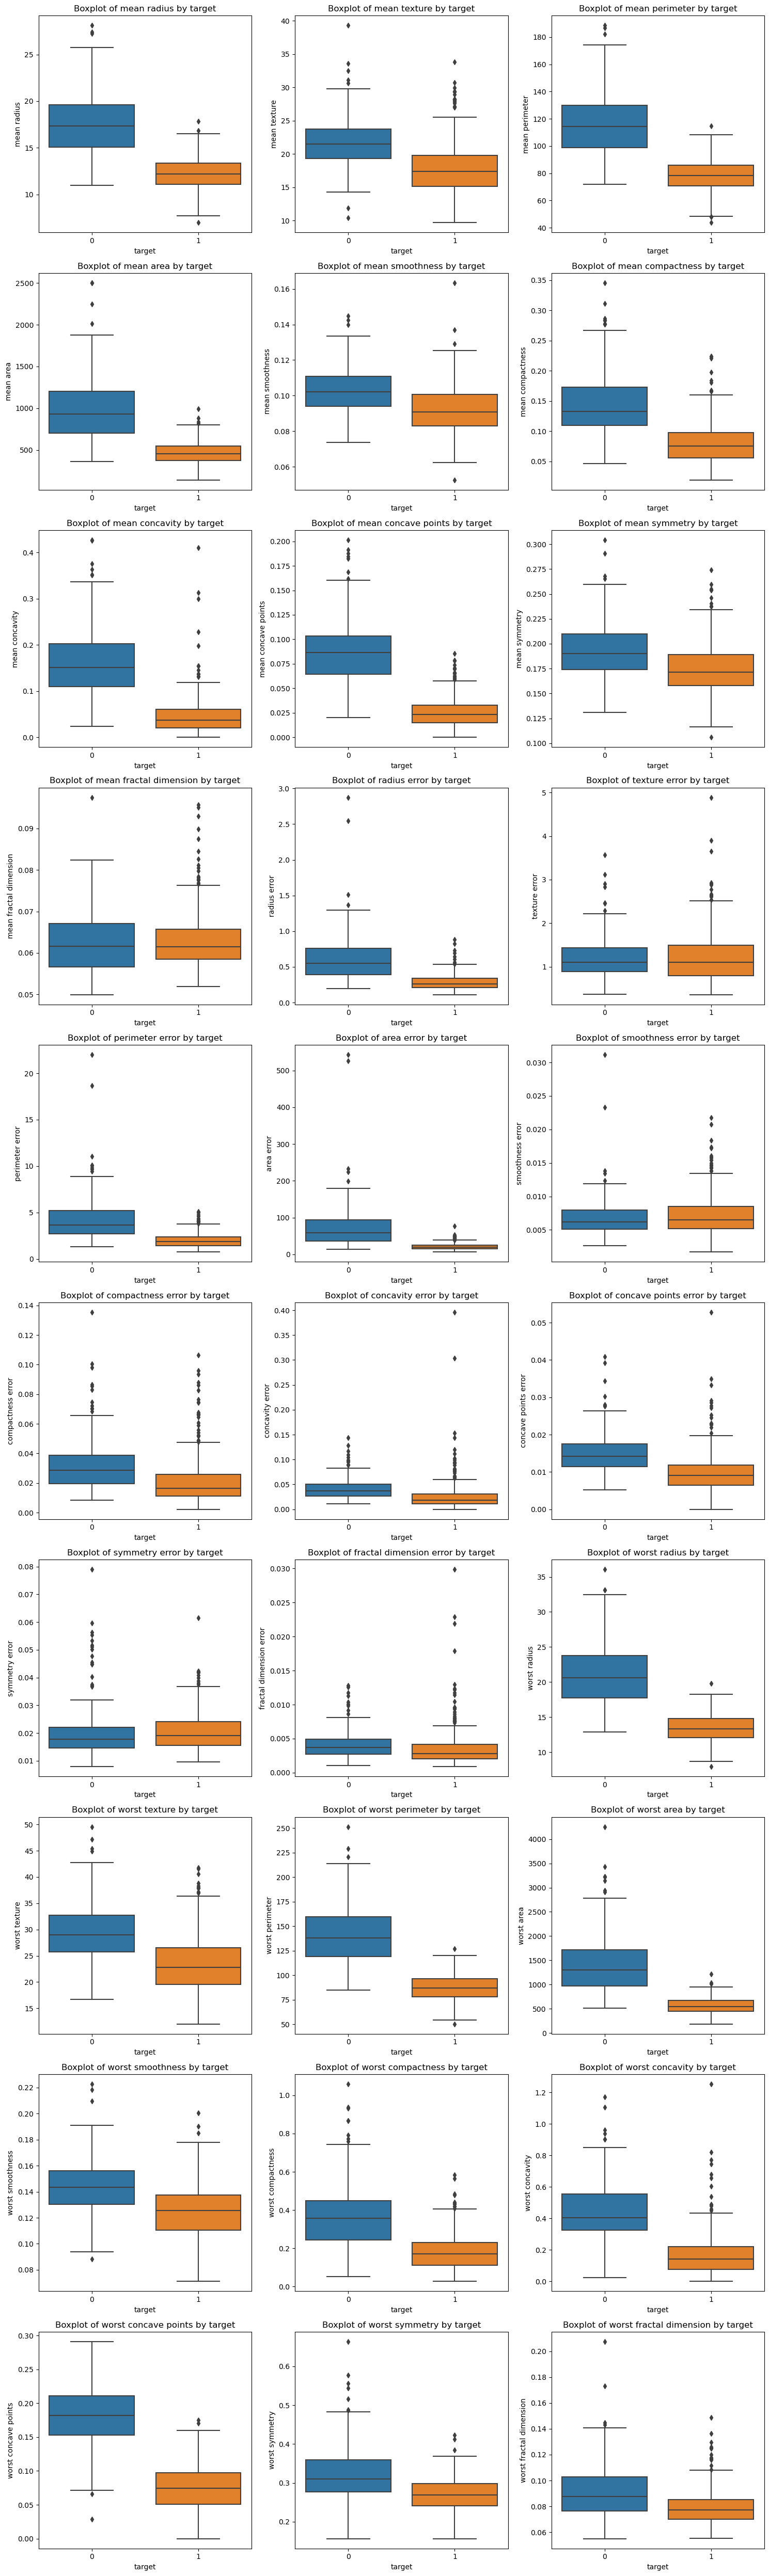

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Define your subplots matrix.
# In this example the fig has 4 rows and 2 columns
df = pd.DataFrame(X, columns=data.feature_names)
target = 'target'
df[target]=data.target
# Calculate number of features
num_features = len(df.columns[:-1])

# Calculate number of rows and columns for subplots
num_rows = (num_features + 2) // 3  # Add 2 to account for the target column and integer division
num_cols = min(3, num_features)  # Limit to 3 columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten axes if necessary (when num_rows = 1)
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Loop through features and create boxplots
for i, feature in enumerate(df.columns[:-1]):  # Exclude the target column
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=target, y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} by {target}')

# Remove any unused subplots
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## How is the F-statistics used in `SelectKBest` with `score_func=f_classif`

The **F-statistics**, or the **F-test**, is commonly used in statistics to compare the means of two or more populations. When used in the `SelectKBest` feature selection method with the `score_func=f_classif`, it serves to rank the features based on their ability to discriminate between classes in a classification problem.

### 1. Feature Scoring
The `f_classif` function calculates the F-statistics for each feature by comparing the variance between the classes and the variance within the classes.

### 2. Ranking Features
The calculated F-statistics scores are used to rank the features. Higher F-statistics scores indicate that the feature is more relevant for distinguishing between classes.

### 3. Feature Selection
`SelectKBest` selects the top 𝑘 features with the highest F-statistics scores, where 𝑘 is a predefined parameter.

By selecting features with the highest F-statistics scores, `SelectKBest` aims to choose those features that contribute the most to the discrimination between classes, thus potentially improving the performance of the classification model.

Keep in mind that `f_classif` assumes that the features follow an ANOVA F-test distribution. It is suitable for continuous features and works well with linear models. If your features don't meet these assumptions, you might want to consider using other feature selection methods or scoring functions that are more appropriate for your data.

In [12]:
# Create pipeline with feature selection and classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('feature_selection', SelectKBest(score_func=f_classif)),  # Select top k features
    ('classifier', SVC(kernel='rbf'))  # Classifier (SVM with RBF kernel)
])

# Define parameter grid for hyperparameter tuning
k_step = 2 # we will try subsets of the feature of sizes that are multiples of 5
param_grid = {
    'feature_selection__k': [i for i in range(k_step, df.shape[1], k_step)], # [5, 10, 15, 20, 25, 30],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1]
}
scoring = 'f1' # The target is binary, therefore the scoring can be
                # simply 'f1', no need for the '_macro' or 'weighted' suffix
cv = 5

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring)

# Train pipeline with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best parameters and best F1-score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best training F1-score:", best_f1)

# Predictions
y_pred = grid_search.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Test F1-score:", f1)


Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'feature_selection__k': 20}
Best training F1-score: 0.984523890746992
Test Accuracy: 0.9649122807017544
Test F1-score: 0.971830985915493


## Extract the selected features
- after fitting the `grid_search` estimator, the `.best_estimator_` attribute contains all the characteristics of the best estimator
- the `.named_steps['feature_selection] extracts the outcome of SelectKBest transformer
- we retrieve the indices of the selected features with the method `.get_support(indices=True)`



In [5]:
selected_features_indices = grid_search.best_estimator_.named_steps['feature_selection'].get_support(indices=True)
selected_features = data.feature_names[selected_features_indices]
print(f"Surviving {len(selected_features)} out of the original {df.columns.shape[0]-1} features")
print("Surviving Features:", selected_features)

Surviving 20 out of the original 30 features
Surviving Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean compactness' 'mean concavity' 'mean concave points' 'radius error'
 'perimeter error' 'area error' 'concave points error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst smoothness'
 'worst compactness' 'worst concavity' 'worst concave points'
 'worst symmetry']


## Show a more detailed analysis of the significance of the features for the classification


In [6]:
f_statistics, p_values = f_classif(X_train,y_train)
selected = [feature in selected_features for feature in df.columns[:-1]]
feature_scores = pd.DataFrame({'f_statistic':f_statistics, 'p_value':p_values, 'selected':selected}
                              , index = df.columns[:-1]).sort_values(by='f_statistic', ascending=False)
feature_scores

,f_statistic,p_value,selected
worst concave points,746.492117,7.751614e-98,True
mean concave points,695.179785,1.570324e-93,True
worst perimeter,681.263759,2.495901e-92,True
worst radius,645.350668,3.688574e-89,True
mean perimeter,522.489267,1.801971e-77,True
worst area,495.787667,9.798902e-75,True
mean radius,482.233945,2.566812e-73,True
mean area,423.654133,6.111971e-67,True
mean concavity,396.662370,7.411691e-64,True
worst concavity,331.330906,5.775897e-56,True


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



## Unsupervised feature selection with PCA
The workflow is the same as before, the only change is in step 3.2, where we use `PCA` instead of `SelectKBest`.

`PCA` is an unsupervised method (i.e. it does not consider the target) that simply linearly transforms the features into a space where the new features are sorted for decreasing *explained variance*, then the parameter `n_components` makes the selection of the most significant ones

In [11]:
# Create pipeline with PCA and classifier
from sklearn.decomposition import PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('PCA', PCA()),  # Select k principal components
    ('classifier', SVC(kernel='rbf'))  # Classifier (SVM with RBF kernel)
])

# Define parameter grid for hyperparameter tuning
k_step = 2 # we will try subsets of the feature of sizes that are multiples of 5
param_grid = {
    'PCA__n_components': [i for i in range(k_step, df.shape[1], k_step)], # [3,6,9,...],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1]
}
scoring = 'f1' # The target is binary, therefore the scoring can be
                # simply 'f1', no need for the '_macro' or 'weighted' suffix
cv = 5

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring)

# Train pipeline with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best parameters and best F1-score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_
print('Pipeline with PCA and SVM')
print("Best Parameters:", best_params)
print("Best training F1-score:", best_f1)

# Predictions
y_pred = grid_search.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Test F1-score:", f1)


Pipeline with PCA and SVM
Best Parameters: {'PCA__n_components': 16, 'classifier__C': 10, 'classifier__gamma': 'scale'}
Best training F1-score: 0.9810176827915328
Test Accuracy: 0.9736842105263158
Test F1-score: 0.979020979020979


## Conclusion
These two experiment show an example where two feature selection methods lead to similar numbers of components (20 vs 16) and similar performance.

These specific conclusions cannot be generalized, it is likely that with different datasets or different classifiers the results may change in favor of one or the other method.

In addition, there are several other supervised and unsupervised feature selection methods that can be used.